In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

In [110]:
# Seaborn 색상 팔레트 적용
palette = sns.color_palette("Set2")

In [111]:
# 📂 데이터 로딩
label_train = pd.read_csv("./data/train/label/1.걸음걸이/train_label.csv")
activity_train = pd.read_csv("./data/train/raw/train_activity.csv")
sleep_train = pd.read_csv("./data/train/raw/train_sleep.csv")
label_val = pd.read_csv("./data/validation/label/1.걸음걸이/validation_label.csv")
activity_val = pd.read_csv("./data/validation/raw/validation_activity.csv")
sleep_val = pd.read_csv("./data/validation/raw/validation_sleep.csv")

# sleep1. sleep_midpoint_at_delta_relative

- 수면 중간지점과 자정과의 차이를 -12시간 ~ +12시간 범위로 변환합니다. 

In [112]:
# midpoint_at_delta 재계산
import numpy as np

# 수면 중간지점과 자정과의 차이를 다시 계산
def recalculate_sleep_midpoint_at_delta(row):
    delta_seconds = row['sleep_midpoint_at_delta']
    
    # 0~24시간 범위를 초과하는 경우 조정 (-12시간 ~ +12시간 범위로 변환)
    if delta_seconds > 12 * 3600:
        delta_seconds -= 24 * 3600
    
    return delta_seconds

# sleep_midpoint_at_delta 재계산 및 업데이트
sleep_train['sleep_midpoint_delta_relative'] = sleep_train.apply(recalculate_sleep_midpoint_at_delta, axis=1)
sleep_val['sleep_midpoint_delta_relative'] = sleep_val.apply(recalculate_sleep_midpoint_at_delta, axis=1)

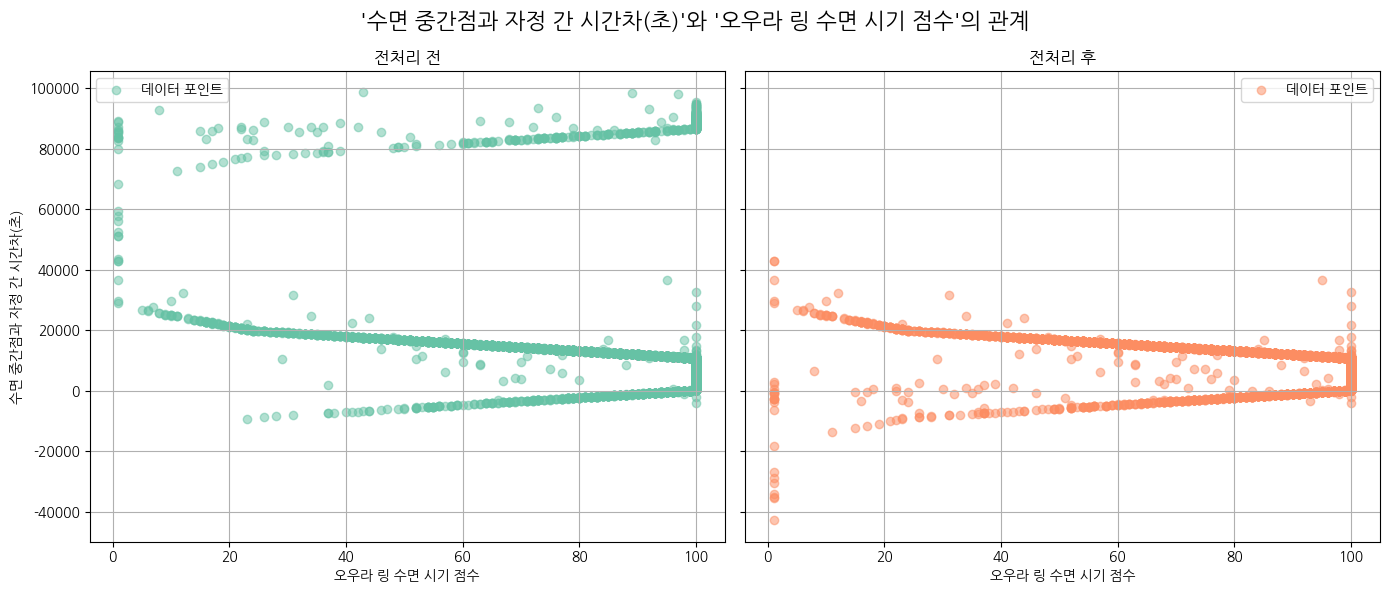

In [113]:
# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Y축 통일 (sharey=True)
fig.suptitle("'수면 중간점과 자정 간 시간차(초)'와 '오우라 링 수면 시기 점수'의 관계", fontsize=16)

# 첫 번째 산점도
axes[0].scatter(sleep_train['sleep_score_alignment'], sleep_train['sleep_midpoint_at_delta'], 
                color=palette[0], alpha=0.5, label='데이터 포인트')
axes[0].set_title("전처리 전")
axes[0].set_xlabel("오우라 링 수면 시기 점수")
axes[0].set_ylabel("수면 중간점과 자정 간 시간차(초)")
axes[0].legend()
axes[0].grid(True)

# 두 번째 산점도
axes[1].scatter(sleep_train['sleep_score_alignment'], sleep_train['sleep_midpoint_delta_relative'], 
                color=palette[1], alpha=0.5, label='데이터 포인트')
axes[1].set_title("전처리 후")
axes[1].set_xlabel("오우라 링 수면 시기 점수")  # X축 레이블 동일하게 유지
axes[1].legend()
axes[1].grid(True)

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

# 로그 데이터 컬럼명 변경

In [114]:
sleep_train.drop(
    columns=['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min'],
    inplace=True)
sleep_val.drop(
    columns=['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min'],
    inplace=True)
sleep_train.rename(
    columns={
        'CONVERT(sleep_hr_5min USING utf8)': 'sleep_hr_5min',
        'CONVERT(sleep_hypnogram_5min USING utf8)': 'sleep_hypnogram_5min',
        'CONVERT(sleep_rmssd_5min USING utf8)': 'sleep_rmssd_5min'
    },
    inplace=True)
sleep_val.rename(
    columns={
        'CONVERT(sleep_hr_5min USING utf8)': 'sleep_hr_5min',
        'CONVERT(sleep_hypnogram_5min USING utf8)': 'sleep_hypnogram_5min',
        'CONVERT(sleep_rmssd_5min USING utf8)': 'sleep_rmssd_5min'
    },
    inplace=True)

activity_train.drop(
    columns=['activity_class_5min', 'activity_met_1min'],
    inplace=True)
activity_val.drop(
    columns=['activity_class_5min', 'activity_met_1min'],
    inplace=True)
activity_train.rename(
    columns={
        'CONVERT(activity_class_5min USING utf8)': 'activity_class_5min',
        'CONVERT(activity_met_1min USING utf8)': 'activity_met_1min',
    },
    inplace=True)
activity_val.rename(
    columns={
        'CONVERT(activity_class_5min USING utf8)': 'activity_class_5min',
        'CONVERT(activity_met_1min USING utf8)': 'activity_met_1min',
    },
    inplace=True)

# sleep_hr_5min 선형보간
- 0값(결측치)들을 선형보간


In [115]:
# 1. sleep_hr_5min 파싱 함수 (0 포함)
def parse_hr(row):
    try:
        return [float(x) for x in row.split('/') if x.strip() != '']
    except:
        return []

# 2. 파싱
sleep_train["sleep_hr_5min"] = sleep_train["sleep_hr_5min"].apply(parse_hr)
sleep_val['sleep_hr_5min'] = sleep_val['sleep_hr_5min'].apply(parse_hr)

# 3. 각 row에서 heart rate가 0인 값의 개수 세기
sleep_train["hr_zero_count"] = sleep_train["sleep_hr_5min"].apply(lambda x: sum(1 for v in x if v == 0))
sleep_val["hr_zero_count"] = sleep_val["sleep_hr_5min"].apply(lambda x: sum(1 for v in x if v == 0))

# 4. 통계 출력
print("====train====")
print("💡 Heart Rate = 0 값 분포")
print(sleep_train["hr_zero_count"].describe())

print("\n📌 0값이 포함된 샘플 수:", (sleep_train["hr_zero_count"] > 0).sum())
print("📌 전체 샘플 수:", len(sleep_train))
print("📌 비율 (%):", round((sleep_train["hr_zero_count"] > 0).mean() * 100, 2), "%")

====train====
💡 Heart Rate = 0 값 분포
count    9705.000000
mean       11.124060
std        10.987264
min         0.000000
25%         4.000000
50%         7.000000
75%        15.000000
max        89.000000
Name: hr_zero_count, dtype: float64

📌 0값이 포함된 샘플 수: 9521
📌 전체 샘플 수: 9705
📌 비율 (%): 98.1 %


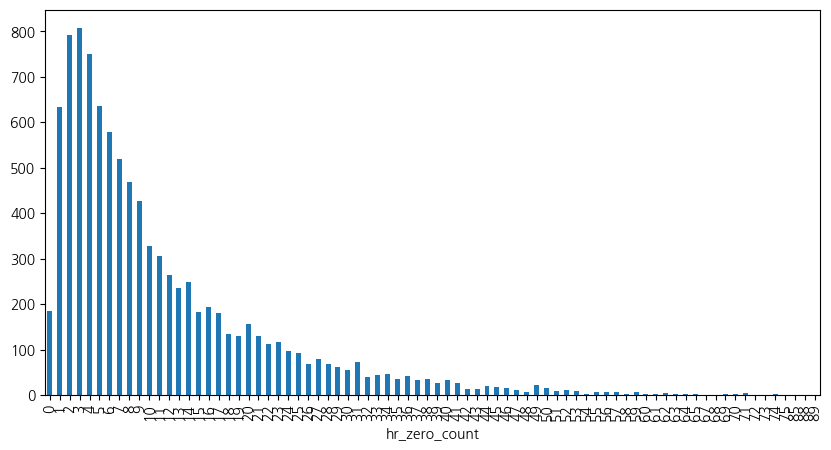

In [116]:
sleep_train['hr_zero_count'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5));

In [117]:
# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(hr_list):
    max_streak = 0
    current_streak = 0
    for val in hr_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 0이 50개 이상 포함된 행 필터링
high_zero_df = sleep_train[sleep_train["hr_zero_count"] >= 50].copy()

# 3. 연속된 0의 최대 길이 및 총 로그 수 계산
high_zero_df["max_zero_streak"] = high_zero_df["sleep_hr_5min"].apply(max_consecutive_zeros)
high_zero_df["total_log_count"] = high_zero_df["sleep_hr_5min"].apply(len)

# 4. 결과 요약
print(f"⚠️ 0값 50개 이상인 샘플 수: {len(high_zero_df)}")
print("\n📊 연속된 0의 최대 길이 통계:")
print(high_zero_df["max_zero_streak"].describe())

# 출력
print("\n📌 연속된 0의 길이 높은 순")
display(high_zero_df[["EMAIL", "hr_zero_count", "max_zero_streak", "total_log_count"]].sort_values(by="max_zero_streak", ascending=False))

====train====
⚠️ 0값 50개 이상인 샘플 수: 111

📊 연속된 0의 최대 길이 통계:
count    111.000000
mean      18.657658
std        8.355179
min        5.000000
25%       13.000000
50%       17.000000
75%       23.000000
max       44.000000
Name: max_zero_streak, dtype: float64

📌 연속된 0의 길이 높은 순


,EMAIL,hr_zero_count,max_zero_streak,total_log_count
6572,nia+139@rowan.kr,62,44,139
9081,nia+369@rowan.kr,61,43,135
3352,nia+331@rowan.kr,52,38,126
4705,nia+015@rowan.kr,51,38,107
590,nia+268@rowan.kr,70,34,181
...,...,...,...,...
1931,nia+428@rowan.kr,52,8,105
6364,nia+126@rowan.kr,50,7,115
2175,nia+283@rowan.kr,53,7,111
1927,nia+428@rowan.kr,55,7,117


## 로그 중 30% 이상 연속된 0 구간이 있는 행 제거

In [118]:
# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(hr_list):
    max_streak = 0
    current_streak = 0
    for val in hr_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
sleep_train["max_zero_streak"] = sleep_train["sleep_hr_5min"].apply(max_consecutive_zeros)
sleep_train["total_log_count"] = sleep_train["sleep_hr_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(sleep_train)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
sleep_train = sleep_train[sleep_train["max_zero_streak"] / sleep_train["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(sleep_train)}")

print("\n====test====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
sleep_val["max_zero_streak"] = sleep_val["sleep_hr_5min"].apply(max_consecutive_zeros)
sleep_val["total_log_count"] = sleep_val["sleep_hr_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(sleep_val)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
sleep_val = sleep_val[sleep_val["max_zero_streak"] / sleep_val["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(sleep_val)}")

====train====
⚠️ 제거된 샘플 수: 9705
✅ 제거 후 남은 샘플 수: 9696

====test====
⚠️ 제거된 샘플 수: 2478
✅ 제거 후 남은 샘플 수: 2477


In [119]:
# 2. 선형 보간 함수: 0을 np.nan으로 바꾸고 interpolate
def interpolate_hr(hr_list):
    arr = np.array(hr_list, dtype='float')
    arr[arr == 0] = np.nan  # 0을 NaN으로 대체
    series = pd.Series(arr).interpolate(method='linear', limit_direction='both')
    return series.tolist()

# 3. 적용
sleep_train["sleep_hr_5min_interpolated"] = sleep_train["sleep_hr_5min"].apply(interpolate_hr)
sleep_val["sleep_hr_5min_interpolated"] = sleep_val["sleep_hr_5min"].apply(interpolate_hr)

- 선형 보간 후 검증

In [120]:
sleep_train["zero_count_before"] = sleep_train["sleep_hr_5min"].apply(lambda x: sum(v == 0 for v in x))
sleep_train["zero_count_after"] = sleep_train["sleep_hr_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

sleep_val["zero_count_before"] = sleep_val["sleep_hr_5min"].apply(lambda x: sum(v == 0 for v in x))
sleep_val["zero_count_after"] = sleep_val["sleep_hr_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

print("✅ Train Set 0값 개수 변화:")
print(sleep_train[["zero_count_before", "zero_count_after"]].describe())

print("\n✅ Validation Set 0값 개수 변화:")
print(sleep_val[["zero_count_before", "zero_count_after"]].describe())

✅ Train Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        9696.000000            9696.0
mean           11.093956               0.0
std            10.941418               0.0
min             0.000000               0.0
25%             4.000000               0.0
50%             7.000000               0.0
75%            15.000000               0.0
max            89.000000               0.0

✅ Validation Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        2477.000000            2477.0
mean           12.129996               0.0
std            11.663603               0.0
min             0.000000               0.0
25%             3.000000               0.0
50%             8.000000               0.0
75%            17.000000               0.0
max            70.000000               0.0


# sleep_rmssd_5min 선형보간

- 0값(결측치)들을 선형보간

In [121]:
# 1. sleep_rmssd_5min 파싱 함수 (0 포함)
def parse_rmssd(row):
    try:
        return [float(x) for x in row.split('/') if x.strip() != '']
    except:
        return []

# 2. 파싱
sleep_train["sleep_rmssd_5min"] = sleep_train["sleep_rmssd_5min"].apply(parse_rmssd)
sleep_val["sleep_rmssd_5min"] = sleep_val["sleep_rmssd_5min"].apply(parse_rmssd)

# 3. 각 row에서 heart rate가 0인 값의 개수 세기
sleep_train["rmssd_zero_count"] = sleep_train["sleep_rmssd_5min"].apply(lambda x: sum(1 for v in x if v == 0))
sleep_val["rmssd_zero_count"] = sleep_val["sleep_rmssd_5min"].apply(lambda x: sum(1 for v in x if v == 0))

# 4. 통계 출력
print("====train====")
print("💡 Heart Rate = 0 값 분포")
print(sleep_train["rmssd_zero_count"].describe())

print("\n📌 0값이 포함된 샘플 수:", (sleep_train["rmssd_zero_count"] > 0).sum())
print("📌 전체 샘플 수:", len(sleep_train))
print("📌 비율 (%):", round((sleep_train["rmssd_zero_count"] > 0).mean() * 100, 2), "%")

====train====
💡 Heart Rate = 0 값 분포
count    9696.000000
mean       11.093956
std        10.941418
min         0.000000
25%         4.000000
50%         7.000000
75%        15.000000
max        89.000000
Name: rmssd_zero_count, dtype: float64

📌 0값이 포함된 샘플 수: 9512
📌 전체 샘플 수: 9696
📌 비율 (%): 98.1 %


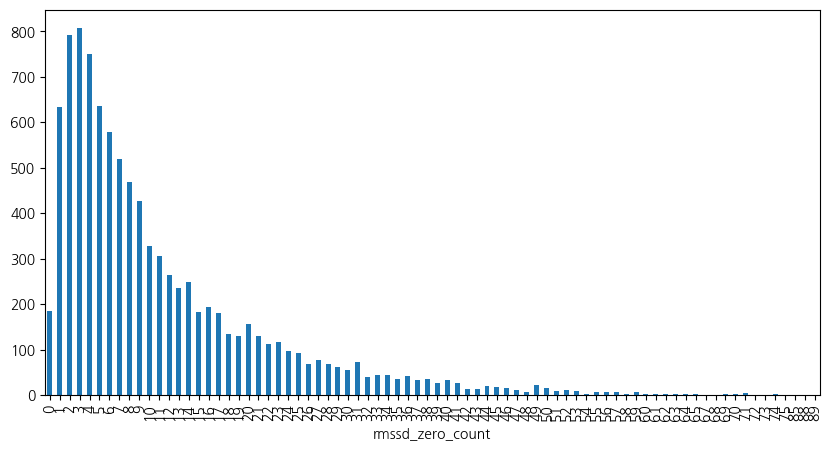

In [122]:
sleep_train['rmssd_zero_count'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5));

In [123]:
# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(rmssd_list):
    max_streak = 0
    current_streak = 0
    for val in rmssd_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 0이 50개 이상 포함된 행 필터링
high_zero_df = sleep_train[sleep_train["rmssd_zero_count"] >= 50].copy()

# 3. 연속된 0의 최대 길이 계산
high_zero_df["max_zero_streak"] = high_zero_df["sleep_rmssd_5min"].apply(max_consecutive_zeros)
high_zero_df["total_log_count"] = high_zero_df["sleep_rmssd_5min"].apply(len)

# 4. 결과 요약
print(f"⚠️ 0값 50개 이상인 샘플 수: {len(high_zero_df)}")
print("\n📊 연속된 0의 최대 길이 통계:")
print(high_zero_df["max_zero_streak"].describe())

# 출력
print("\n📌 연속된 0의 길이 높은 순")
print(high_zero_df[["EMAIL", "rmssd_zero_count", "max_zero_streak", "total_log_count"]].sort_values(by="max_zero_streak", ascending=False))

====train====
⚠️ 0값 50개 이상인 샘플 수: 107

📊 연속된 0의 최대 길이 통계:
count    107.000000
mean      17.831776
std        7.283331
min        5.000000
25%       13.000000
50%       17.000000
75%       22.000000
max       34.000000
Name: max_zero_streak, dtype: float64

📌 연속된 0의 길이 높은 순
                 EMAIL  rmssd_zero_count  max_zero_streak  total_log_count
1276  nia+288@rowan.kr                85               34              181
590   nia+268@rowan.kr                70               34              181
8384  nia+371@rowan.kr                63               33              131
8101  nia+306@rowan.kr                50               33              119
2707  nia+448@rowan.kr                53               33              111
...                ...               ...              ...              ...
1931  nia+428@rowan.kr                52                8              105
2175  nia+283@rowan.kr                53                7              111
1927  nia+428@rowan.kr                55           

## 로그 중 30% 이상 연속된 0 구간이 있는 행 제거

In [124]:
# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(hr_list):
    max_streak = 0
    current_streak = 0
    for val in hr_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
sleep_train["max_zero_streak"] = sleep_train["sleep_rmssd_5min"].apply(max_consecutive_zeros)
sleep_train["total_log_count"] = sleep_train["sleep_rmssd_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(sleep_train)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
sleep_train = sleep_train[sleep_train["max_zero_streak"] / sleep_train["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(sleep_train)}")

print("\n====test====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
sleep_val["max_zero_streak"] = sleep_val["sleep_rmssd_5min"].apply(max_consecutive_zeros)
sleep_val["total_log_count"] = sleep_val["sleep_rmssd_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(sleep_val)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
sleep_val = sleep_val[sleep_val["max_zero_streak"] / sleep_val["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(sleep_val)}")

====train====
⚠️ 제거된 샘플 수: 9696
✅ 제거 후 남은 샘플 수: 9696

====test====
⚠️ 제거된 샘플 수: 2477
✅ 제거 후 남은 샘플 수: 2477


In [125]:
# 2. 선형 보간 함수: 0을 np.nan으로 바꾸고 interpolate
def interpolate_rmssd(rmssd_list):
    arr = np.array(rmssd_list, dtype='float')
    arr[arr == 0] = np.nan  # 0을 NaN으로 대체
    series = pd.Series(arr).interpolate(method='linear', limit_direction='both')
    return series.tolist()

# 3. 적용
sleep_train["sleep_rmssd_5min_interpolated"] = sleep_train["sleep_rmssd_5min"].apply(interpolate_rmssd)
sleep_val["sleep_rmssd_5min_interpolated"] = sleep_val["sleep_rmssd_5min"].apply(interpolate_rmssd)

- 선형 보간 후 검증

In [126]:
# 1. 보간 전후 0값 개수 비교
sleep_train["zero_count_before"] = sleep_train["sleep_rmssd_5min"].apply(lambda x: sum(v == 0 for v in x))
sleep_train["zero_count_after"] = sleep_train["sleep_rmssd_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

sleep_val["zero_count_before"] = sleep_val["sleep_rmssd_5min"].apply(lambda x: sum(v == 0 for v in x))
sleep_val["zero_count_after"] = sleep_val["sleep_rmssd_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

print("✅ Train Set 0값 개수 변화:")
print(sleep_train[["zero_count_before", "zero_count_after"]].describe())

print("\n✅ Validation Set 0값 개수 변화:")
print(sleep_val[["zero_count_before", "zero_count_after"]].describe())

✅ Train Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        9696.000000            9696.0
mean           11.093956               0.0
std            10.941418               0.0
min             0.000000               0.0
25%             4.000000               0.0
50%             7.000000               0.0
75%            15.000000               0.0
max            89.000000               0.0

✅ Validation Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        2477.000000            2477.0
mean           12.129996               0.0
std            11.663603               0.0
min             0.000000               0.0
25%             3.000000               0.0
50%             8.000000               0.0
75%            17.000000               0.0
max            70.000000               0.0


# sleep2. var_sleep_time_to_hr_lowest

- 사람별 수면 중 최저심박수에 도달하는 시간의 분산

In [127]:
def compute_time_to_hr_lowest(hr_list):
    if len(hr_list) == 0:
        return np.nan
    min_idx = np.argmin(hr_list)
    return min_idx * 5  # 5분 간격

sleep_train["sleep_time_to_hr_lowest"] = sleep_train["sleep_hr_5min_interpolated"].apply(compute_time_to_hr_lowest)
sleep_val["sleep_time_to_hr_lowest"] = sleep_val["sleep_hr_5min_interpolated"].apply(compute_time_to_hr_lowest)

def add_variance_feature(df, feature_col):
    person_var_df = df.groupby("EMAIL")[feature_col].var().reset_index()
    person_var_df.rename(columns={feature_col: f"var_{feature_col}"}, inplace=True)
    df = pd.merge(df, person_var_df, on="EMAIL", how="left")
    return df

sleep_train = add_variance_feature(sleep_train, "sleep_time_to_hr_lowest")
sleep_val = add_variance_feature(sleep_val, "sleep_time_to_hr_lowest")

# sleep3. sleep_temperature_delta_14_sliding_median
- 수면 체온 변화량에 대해, 과거 14일간의 중앙값

In [128]:
def add_sliding_temperature_feature(df, window_size=14):
    result_list = []
    users = df["EMAIL"].unique()

    for email in users:
        user_df = df[df["EMAIL"] == email].sort_values("sleep_bedtime_start").drop_duplicates("sleep_bedtime_start")
        user_df = user_df.copy()  # 경고 방지용

        temp_list = []
        for i in range(len(user_df)):
            window = user_df.iloc[max(0, i - window_size + 1):i + 1]
            median_temp = window["sleep_temperature_delta"].median()
            temp_list.append(median_temp)

        user_df["sleep_temperature_delta_14_sliding_median"] = temp_list
        result_list.append(user_df)

    # 모든 사용자 병합
    full_df = pd.concat(result_list, axis=0).reset_index(drop=True)
    return full_df

sleep_train = add_sliding_temperature_feature(sleep_train)
sleep_val = add_sliding_temperature_feature(sleep_val)

# nia+354@rowan.kr, nia+396@rowan.kr 제거

- 건강이상자로 의심되는 CN 두명의 데이터 제거

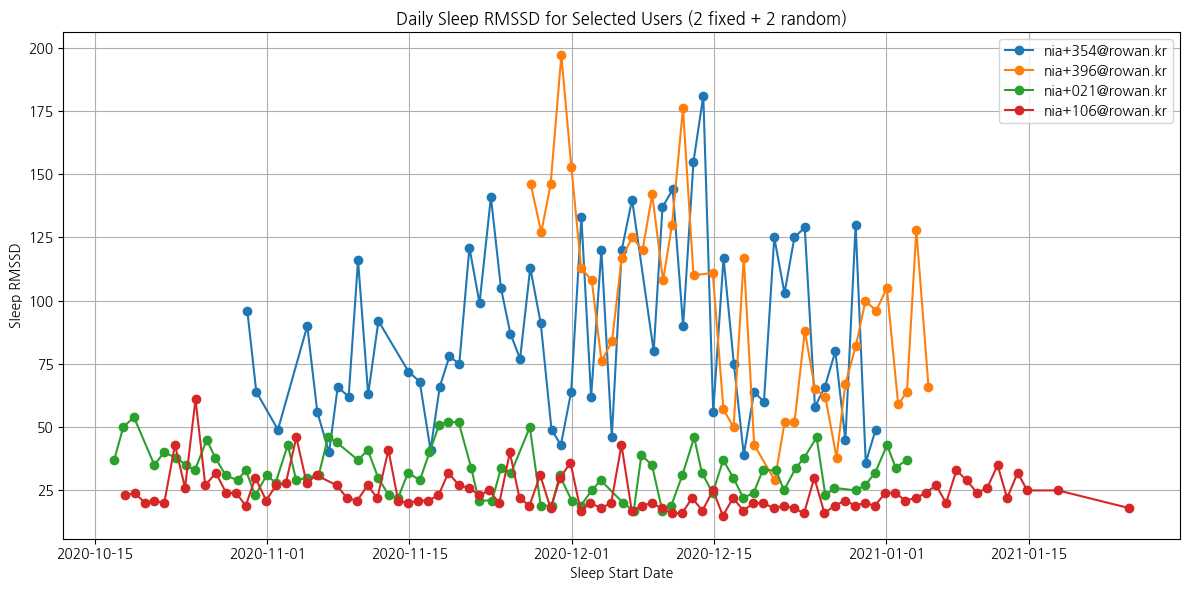

In [129]:
sleep_train = sleep_train[~sleep_train['EMAIL'].isin(['nia+354@rowan.kr', 'nia+396@rowan.kr'])]

In [130]:
sleep_train.columns

Index(['EMAIL', 'sleep_awake', 'sleep_bedtime_end', 'sleep_bedtime_start',
       'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_average', 'sleep_hr_lowest',
       'sleep_is_longest', 'sleep_light', 'sleep_midpoint_at_delta',
       'sleep_midpoint_time', 'sleep_onset_latency', 'sleep_period_id',
       'sleep_rem', 'sleep_restless', 'sleep_rmssd', 'sleep_score',
       'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_disturbances',
       'sleep_score_efficiency', 'sleep_score_latency', 'sleep_score_rem',
       'sleep_score_total', 'sleep_temperature_delta',
       'sleep_temperature_deviation', 'sleep_total', 'sleep_hr_5min',
       'sleep_hypnogram_5min', 'sleep_rmssd_5min',
       'sleep_midpoint_delta_relative', 'hr_zero_count', 'max_zero_streak',
       'total_log_count', 'sleep_hr_5min_interpolated', 'zero_count_before',
       'zero_count_after', 'rmssd_zero_count', 'sleep_rmssd_5min_interpolated',
       'sleep_time_to_h

In [131]:
drop_columns = ['sleep_midpoint_at_delta', 
        'sleep_temperature_deviation',
        'sleep_is_longest',
        'sleep_period_id',
        'sleep_score_efficiency',
        'sleep_score_deep',
        'sleep_score_rem',
        'sleep_score_total',
        'zero_count_before',
        'zero_count_after',
        'hr_zero_count',
        'max_zero_streak',
        'rmssd_zero_count',
        'total_log_count',
        'sleep_time_to_hr_lowest',
        'sleep_temperature_delta',
        'sleep_score_alignment',
]

sleep_train.drop(columns=drop_columns, inplace=True)
sleep_val.drop(columns=drop_columns, inplace=True)

In [132]:
sleep_train.to_csv("./data/preprocessed/train/train_sleep_preprocessed.csv", index=False)
sleep_val.to_csv("./data/preprocessed/validation/validation_sleep_preprocessed.csv", index=False)
activity_train.to_csv("./data/preprocessed/train/train_activity_preprocessed.csv", index=False)
activity_val.to_csv("./data/preprocessed/validation/validation_activity_preprocessed.csv", index=False)
label_train.to_csv("./data/preprocessed/train/train_label_preprocessed.csv", index=False)
label_val.to_csv("./data/preprocessed/validation/validation_label_preprocessed.csv", index=False)